In [9]:
import pandas as pd

# === 1. Load Data ===
peace_df = pd.read_csv("ucdp-peace-agreements-221.csv")
term_df = pd.read_csv("ucdp-term-dyad-3-2021.csv")

# === 2. Parse Dates ===
peace_df['pa_date'] = pd.to_datetime(peace_df['pa_date'], errors='coerce')
if 'dateintervalstart_meta' in peace_df.columns:
    peace_df['dateintervalstart_meta'] = pd.to_datetime(peace_df['dateintervalstart_meta'], errors='coerce')

# Use pa_date if valid, otherwise fallback to dateintervalstart_meta
peace_df['peace_date'] = peace_df['pa_date']
mask = (peace_df['peace_date'].isna()) | (peace_df['peace_date'] == pd.Timestamp('1975-01-01'))
if 'dateintervalstart_meta' in peace_df.columns:
    peace_df.loc[mask, 'peace_date'] = peace_df.loc[mask, 'dateintervalstart_meta']

# Remove rows with missing or still-placeholder dates
peace_df = peace_df[peace_df['peace_date'].notna()]
peace_df = peace_df[peace_df['peace_date'] != pd.Timestamp('1975-01-01')]

# Standardize conflict_id and parse dates in term_df
peace_df['conflict_id'] = pd.to_numeric(peace_df['conflict_id'], errors='coerce').astype('Int64')
term_df['conflict_id'] = pd.to_numeric(term_df['conflict_id'], errors='coerce').astype('Int64')
term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
if 'ependdate' in term_df.columns:
    term_df['end_date'] = pd.to_datetime(term_df['ependdate'], errors='coerce')
elif 'end_date' in term_df.columns:
    term_df['end_date'] = pd.to_datetime(term_df['end_date'], errors='coerce')

# Drop rows with missing key fields
peace_df = peace_df.dropna(subset=['conflict_id', 'peace_date'])
term_df = term_df.dropna(subset=['conflict_id', 'start_date', 'end_date'])

# === 3. Merge Peace Agreements with Conflict Episodes ===
merged = pd.merge(peace_df, term_df, on="conflict_id", how="inner")

# Only keep peace agreements that fall within the conflict episode
merged = merged[
    (merged['peace_date'] >= merged['start_date']) &
    (merged['peace_date'] <= merged['end_date'])
].copy()

# === 4. Calculate Post-Treaty Duration and Resume Flag ===
merged["duration_after_peace"] = (merged["end_date"] - merged["peace_date"]).dt.days
merged["possible_resume"] = merged["duration_after_peace"] < 730  # e.g., resumed if ended within 2 years

# === 5. Save Final Matched File ===
cols_to_keep = [
    "conflict_name", "dyad_name", "location", "side_a", "side_b", "intensity_level", "region",
    "start_date", "peace_date", "end_date", "duration_after_peace", "possible_resume"
]
cols_to_keep = [col for col in cols_to_keep if col in merged.columns]
merged[cols_to_keep].to_csv("matched_peace_conflict_episodes.csv", index=False)

# === 6. Preview ===
print("✅ Peace agreements matched and saved.")
print(merged[cols_to_keep].head())


✅ Peace agreements matched and saved.
             conflict_name                                          dyad_name  \
1  Afghanistan: Government  Government of Afghanistan - Mahaz-i Milli-yi I...   
2  Afghanistan: Government  Government of Afghanistan - Mahaz-i Milli-yi I...   
4  Afghanistan: Government  Government of Afghanistan - Mahaz-i Milli-yi I...   
5  Afghanistan: Government  Government of Afghanistan - Mahaz-i Milli-yi I...   
6  Afghanistan: Government  Government of Afghanistan - Mahaz-i Milli-yi I...   

      location                     side_a                             side_b  \
1  Afghanistan  Government of Afghanistan  Jam'iyyat-i Islami-yi Afghanistan   
2  Afghanistan  Government of Afghanistan  Jam'iyyat-i Islami-yi Afghanistan   
4  Afghanistan  Government of Afghanistan       Hizb-i Islami-yi Afghanistan   
5  Afghanistan  Government of Afghanistan       Hizb-i Islami-yi Afghanistan   
6  Afghanistan  Government of Afghanistan       Hizb-i Islami-yi Afghanista

/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_20637/1938892988.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_20637/1938892988.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  term_df['end_date'] = pd.to_datetime(term_df['ependdate'], errors='coerce')


## Match Peace to Conflict Episodes

In [13]:
import pandas as pd

# === 1. Load Data ===
peace_df = pd.read_csv("peace_agreement_summary.csv")
term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")

# === 2. Standardize Columns and Types ===
# Rename for consistency
term_df = term_df.rename(columns={'ependdate': 'end_date'})

# Ensure conflict_id is numeric and consistent
peace_df['conflict_id'] = pd.to_numeric(peace_df['conflict_id'], errors='coerce').astype('Int64')
term_df['conflict_id'] = pd.to_numeric(term_df['conflict_id'], errors='coerce').astype('Int64')

# === 3. Parse Dates ===
peace_df['peace_date'] = pd.to_datetime(peace_df['peace_date'], errors='coerce')
term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
term_df['end_date'] = pd.to_datetime(term_df['end_date'], errors='coerce')

# === 4. Clean Peace Dates ===
# Drop placeholder or missing peace dates (e.g. 1975-01-01)
peace_df = peace_df[
    (peace_df['peace_date'].notna()) &
    (peace_df['peace_date'] != pd.Timestamp("1975-01-01"))
]

# Drop rows with missing core fields
peace_df = peace_df.dropna(subset=['conflict_id'])
term_df = term_df.dropna(subset=['conflict_id', 'start_date', 'end_date'])

# === 5. Merge Peace Agreements with Conflict Episodes ===
merged = pd.merge(peace_df, term_df, on="conflict_id", how="inner")

# Keep only rows where the peace agreement occurred during the war
merged = merged[
    (merged['peace_date'] >= merged['start_date']) &
    (merged['peace_date'] <= merged['end_date'])
].copy()

# === 6. Compute Post-Treaty Duration and Flags ===
merged["duration_after_peace"] = (merged["end_date"] - merged["peace_date"]).dt.days
merged["possible_resume"] = merged["duration_after_peace"] < 730  # Less than 2 years after treaty

# === 7. Save Final Output ===
merged.to_csv("matched_peace_conflict_episodes.csv", index=False)

# === 8. Preview ===
print("✅ Peace agreements matched and saved.")
print(merged[["conflict_name", "peace_date", "start_date", "end_date", "duration_after_peace", "possible_resume"]].head())
print("✅ Peace agreements matched and saved.")
print("\n📅 Peace Dates in Matched Conflicts:")
print(merged[['conflict_name', 'peace_date']].drop_duplicates().sort_values('peace_date').to_string(index=False))


✅ Peace agreements matched and saved.
Empty DataFrame
Columns: [conflict_name, peace_date, start_date, end_date, duration_after_peace, possible_resume]
Index: []
✅ Peace agreements matched and saved.

📅 Peace Dates in Matched Conflicts:
Empty DataFrame
Columns: [conflict_name, peace_date]
Index: []


In [16]:
import pandas as pd

# Load original full UCDP peace agreement file
df = pd.read_csv("ucdp-peace-agreements-221.csv")

# Parse actual peace dates
df['peace_date'] = pd.to_datetime(df['pa_date'], errors='coerce')

# Drop rows with missing or placeholder dates
df = df[(df['peace_date'].notna()) & (df['peace_date'] != pd.Timestamp("1975-01-01"))]

# Create a clean summary file
summary_df = df[['paid', 'conflict_id', 'dyad_name', 'conflict_name', 'peace_date']].drop_duplicates()

# Export to new summary file
summary_df.to_csv("peace_agreement_summary.csv", index=False)

print("✅ Rebuilt peace_agreement_summary.csv with", len(summary_df), "valid agreements.")


✅ Rebuilt peace_agreement_summary.csv with 374 valid agreements.


In [17]:
import pandas as pd

# === 1. Load Cleaned Data ===
peace_df = pd.read_csv("peace_agreement_summary.csv")
term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")

# === 2. Standardize IDs and Dates ===
term_df = term_df.rename(columns={'ependdate': 'end_date'})
peace_df['conflict_id'] = pd.to_numeric(peace_df['conflict_id'], errors='coerce').astype('Int64')
term_df['conflict_id'] = pd.to_numeric(term_df['conflict_id'], errors='coerce').astype('Int64')

peace_df['peace_date'] = pd.to_datetime(peace_df['peace_date'], errors='coerce')
term_df['start_date'] = pd.to_datetime(term_df['start_date'], errors='coerce')
term_df['end_date'] = pd.to_datetime(term_df['end_date'], errors='coerce')

# === 3. Filter out bad data ===
peace_df = peace_df[
    (peace_df['peace_date'].notna()) &
    (peace_df['peace_date'] != pd.Timestamp("1975-01-01"))
]
peace_df = peace_df.dropna(subset=['conflict_id'])
term_df = term_df.dropna(subset=['conflict_id', 'start_date', 'end_date'])

# === 4. Merge and Match Treaties During Conflict Episodes ===
merged = pd.merge(peace_df, term_df, on="conflict_id", how="inner")
merged = merged[
    (merged['peace_date'] >= merged['start_date']) &
    (merged['peace_date'] <= merged['end_date'])
].copy()

# === 5. Compute Duration After Treaty and Flags ===
merged["duration_after_peace"] = (merged["end_date"] - merged["peace_date"]).dt.days
merged["possible_resume"] = merged["duration_after_peace"] < 730

# === 6. Save Output ===
merged.to_csv("matched_peace_conflict_episodes.csv", index=False)

# === 7. Preview ===
print("✅ Peace agreements matched and saved.")
print(merged[["conflict_name", "peace_date", "start_date", "end_date", "duration_after_peace", "possible_resume"]].head())


✅ Peace agreements matched and saved.
             conflict_name peace_date start_date   end_date  \
1  Afghanistan: Government 1992-04-24 1975-07-02 1992-04-28   
2  Afghanistan: Government 1992-04-24 1975-07-02 1996-12-31   
4  Afghanistan: Government 1992-04-24 1980-03-31 1995-12-31   
5  Afghanistan: Government 1992-04-24 1980-03-31 2003-12-31   
6  Afghanistan: Government 1992-04-24 1980-03-31 2006-12-31   

   duration_after_peace  possible_resume  
1                     4             True  
2                  1712            False  
4                  1346            False  
5                  4268            False  
6                  5364            False  


In [18]:
import pandas as pd

# Load files
peace_df = pd.read_csv("peace_agreement_summary.csv")
term_df = pd.read_csv("termination_summary.csv")

# Show column names
print("🕊️ Peace Agreement Columns:")
print(peace_df.columns.tolist())

print("\n📜 Termination Columns:")
print(term_df.columns.tolist())


🕊️ Peace Agreement Columns:
['paid', 'conflict_id', 'dyad_name', 'conflict_name', 'peace_date']

📜 Termination Columns:
['dyad_id', 'start_date', 'end_date', 'outcome']


/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T/ipykernel_20637/1016189293.py:36: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/chivo/.pyenv/versions/3.10.12/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


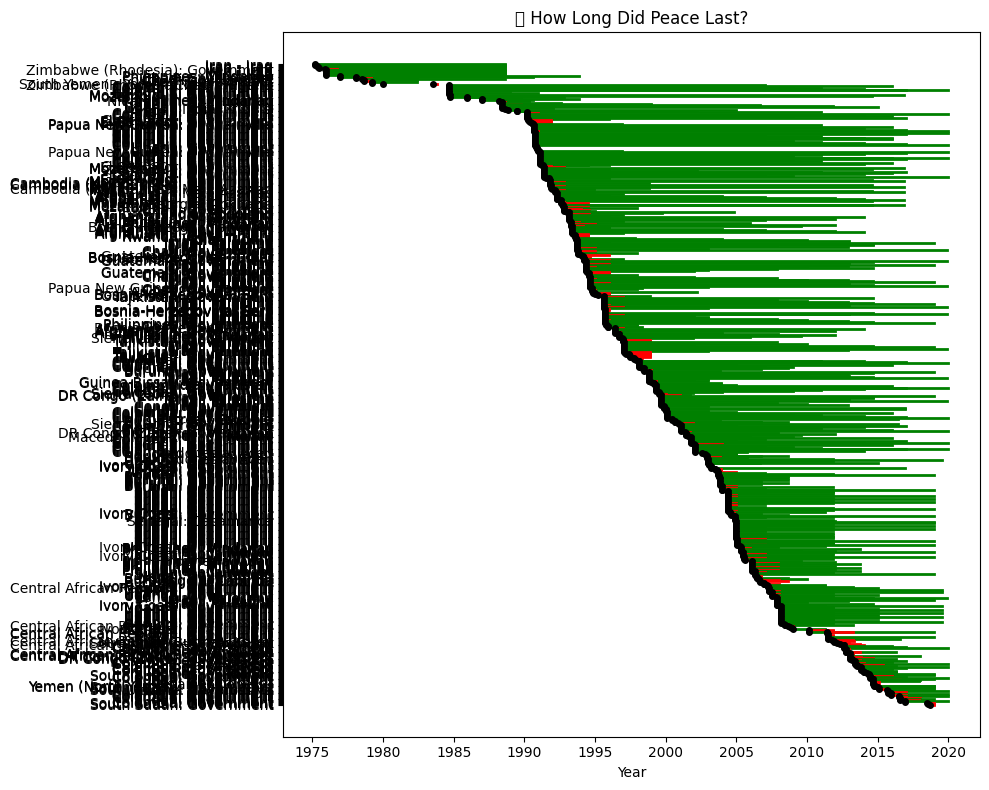

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("matched_peace_conflict_episodes.csv")
df['peace_date'] = pd.to_datetime(df['peace_date'], errors='coerce')
df = df[df['peace_date'].notna()]
df = df[df['peace_date'] != pd.Timestamp('1975-01-01')]
df = df[(df['peace_date'] >= pd.to_datetime(df['start_date'])) & (df['peace_date'] <= pd.to_datetime(df['end_date']))]
df.to_csv("matched_peace_conflict_episodes.csv", index=False)

# Sort by peace_date for visual clarity
df = df.sort_values("peace_date").reset_index(drop=True)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 8))

for i, row in df.iterrows():
    start = row["peace_date"]
    end = row["end_date"]
    held = not row["possible_resume"]
    color = "green" if held else "red"
    
    # Draw horizontal line
    ax.plot([start, end], [i, i], color=color, linewidth=2)
    
    # Optional: mark peace event
    ax.plot(start, i, marker='o', color='black', markersize=4)

# Format
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df["conflict_name"])
ax.invert_yaxis()  # Most recent at top
ax.set_title("⏳ How Long Did Peace Last?")
ax.set_xlabel("Year")
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd

# Load the matched data
df = pd.read_csv("matched_peace_conflict_episodes.csv", parse_dates=["peace_date", "end_date"])

# Function to expand rows into years
def expand_conflict_years(row):
    years = pd.date_range(row['peace_date'], row['end_date'], freq='YS').year
    return pd.DataFrame({
        'conflict_name': row['conflict_name'],
        'year': years,
        'peace_date': row['peace_date'],
        'end_date': row['end_date'],
        'resumed': row['possible_resume']
    })

# Apply to all rows
expanded = pd.concat([expand_conflict_years(row) for _, row in df.iterrows()], ignore_index=True)

# Save for Observable
expanded.to_csv("observable_conflict_lifelines.csv", index=False)
print("✅ File saved: observable_conflict_lifelines.csv")


✅ File saved: observable_conflict_lifelines.csv


In [ ]:
import pandas as pd

term_df = pd.read_excel("ucdp-term-dyad-3-2021.xlsx", sheet_name="dataset")
print(term_df.columns.tolist())


['dyadep_id', 'dyadepisode', 'type_of_conflict2', 'dyadcount', 'dyadterm', 'ependdate', 'ependprec', 'outcome', 'cfiredate', 'peagdate', 'recur', 'version', 'conflict_id', 'dyad_id', 'year', 'location', 'side_a', 'side_a_id', 'side_a_2nd', 'side_b', 'side_b_id', 'side_b_2nd', 'incompatibility', 'territory_name', 'intensity_level', 'type_of_conflict', 'start_date', 'start_prec', 'start_date2', 'start_prec2', 'gwno_loc', 'region']
